### Khai báo các thư viện cần thiết

In [1]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Đọc dữ liệu đầu vào

In [ ]:
# **1️⃣ Tải dữ liệu**
data = pd.read_csv(r"//kaggle/input/fdsfsdf/Data.csv")

In [3]:
X = data['Content'].astype(str).tolist()
y = data['Label'].astype(str).tolist()

### Mã hóa cho nhãn bằng phương pháp label encoder

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y).astype(np.int32)

### Tải phoBer và model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2",use_fast=False)
bert_model = TFAutoModel.from_pretrained("vinai/phobert-base-v2", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

### Chia tập train, test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42)

### Mã hóa văn bản và chia nhỏ văn bản thành các đoạn hợp lệ 

In [ ]:
def split_text_into_chunks(text, tokenizer, max_len=256):
    """Chia văn bản thành các đoạn nhỏ, giữ token đặc biệt [CLS] và [SEP]"""
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = [tokens[i:i+max_len] for i in range(0, len(tokens), max_len)]
    return [[tokenizer.cls_token_id] + chunk + [tokenizer.sep_token_id] for chunk in chunks]

In [8]:
X_train_split = [split_text_into_chunks(text, tokenizer) for text in X_train]
X_test_split = [split_text_into_chunks(text, tokenizer) for text in X_test]

### Chuẩn bị dữ liệu đầu vào

In [9]:
def encode_texts(tokenized_texts, tokenizer, max_length=256):
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_texts, maxlen=max_length, dtype="int32", padding="post", truncating="post", value=tokenizer.pad_token_id
    )
    
    attention_masks = np.where(input_ids != tokenizer.pad_token_id, 1, 0)
    
    return {"input_ids": input_ids, "attention_mask": attention_masks}

In [ ]:
### Làm phẳng dữ liệu 
X_train_flat = [chunk for text_chunks in X_train_split for chunk in text_chunks]
X_test_flat = [chunk for text_chunks in X_test_split for chunk in text_chunks]


In [ ]:
X_train_encoded = encode_texts(X_train_flat, tokenizer, max_length=256)
X_test_encoded = encode_texts(X_test_flat, tokenizer, max_length=256)

### Gán nhãn cho từng đoạn

In [ ]:
y_train_expanded = np.array([y_train[i] for i, text_chunks in enumerate(X_train_split) for _ in text_chunks])
y_test_expanded = np.array([y_test[i] for i, text_chunks in enumerate(X_test_split) for _ in text_chunks])


In [13]:
print(f"🔹 Số mẫu trong X_train_encoded: {len(X_train_encoded['input_ids'])}") 
print(f"🔹 Số mẫu trong y_train: {len(y_train_expanded)}") 

🔹 Số mẫu trong X_train_encoded: 96794
🔹 Số mẫu trong y_train: 96794


### Chuyển dữ liệu thành TensorFlow Dataset

In [ ]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train_encoded), y_train_expanded)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(X_test_encoded), y_test_expanded)).batch(batch_size)

### Xây dựng model

In [ ]:
def build_model(bert_model, num_classes):
    input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="attention_mask")

    # Dùng PhoBERT trực tiếp
    bert_output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Lấy vector của token [CLS] (batch_size, hidden_dim)
    cls_output = bert_output.last_hidden_state[:, 0, :]  

    # Thêm Dense Layers
    dense = tf.keras.layers.Dense(64)(cls_output)
    dense = tf.keras.layers.LayerNormalization()(dense)  # Dùng LayerNorm thay vì BatchNorm
    dense = tf.keras.layers.LeakyReLU()(dense)  # Dùng LeakyReLU thay vì ReLU
    dense = tf.keras.layers.Dropout(0.4)(dense)  # Tăng Dropout để tránh overfitting

    # Dense Layer 2
    dense = tf.keras.layers.Dense(32)(dense)
    dense = tf.keras.layers.LayerNormalization()(dense)
    dense = tf.keras.layers.LeakyReLU()(dense)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    
    # Output Layer
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(dense)

    # Xây dựng mô hình
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    # Compile mô hình
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss='sparse_categorical_crossentropy',  
                  metrics=['accuracy'])
    
    return model


### Chia tập val = 15% tập train

In [16]:
# Số lượng phần tử trong tập train
total_size = sum(1 for _ in train_dataset)
val_size = int(0.15 * total_size)  # 15% cho validation

# Tách train/validation từ tf.data.Dataset
val_dataset = train_dataset.take(val_size)
train_dataset = train_dataset.skip(val_size)

In [17]:
import tensorflow as tf
from transformers import AutoModel

# Kích hoạt MirroredStrategy để tận dụng 2 GPU
strategy = tf.distribute.MirroredStrategy()

# Tạo PhoBERT bên trong strategy.scope()
with strategy.scope():
    bert_model = TFAutoModel.from_pretrained("vinai/phobert-base")

    num_classes = len(label_encoder.classes_)
    model = build_model(bert_model, num_classes)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Tăng tốc Data Pipeline
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model_1 (TFRobe  TFBaseModelOutputWithPooli   1349982   ['input_ids[0][0]',           
 rtaModel)                   ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                       

### Huấn luyện model

In [19]:
best_val_loss = float('inf')

# Tiến hành huấn luyện
for epoch in range(10):
    history = model.fit(
        train_dataset,
        epochs=1,
        validation_data=val_dataset
    )

    # Kiểm tra val_loss
    val_loss = history.history['val_loss'][-1]
    print(f"Epoch {epoch+1} - val_loss: {val_loss}")

    # Lưu mô hình nếu val_loss giảm
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save("best1111_model", save_format="tf")
        print(f"Epoch {epoch+1}: Improved val_loss, saving model!")

1287/1287 [==============================] - 2855s 2s/step - loss: 1.2353 - accuracy: 0.7040 - val_loss: 0.6785 - val_accuracy: 0.8383
Epoch 1 - val_loss: 0.6785427331924438
Epoch 1: Improved val_loss, saving model!
1287/1287 [==============================] - 2755s 2s/step - loss: 0.8503 - accuracy: 0.8387 - val_loss: 0.5653 - val_accuracy: 0.8646
Epoch 2 - val_loss: 0.5653296709060669
Epoch 2: Improved val_loss, saving model!
1287/1287 [==============================] - 2753s 2s/step - loss: 0.7098 - accuracy: 0.8716 - val_loss: 0.5392 - val_accuracy: 0.8691
Epoch 3 - val_loss: 0.5391847491264343
Epoch 3: Improved val_loss, saving model!
1287/1287 [==============================] - 2756s 2s/step - loss: 0.5931 - accuracy: 0.8980 - val_loss: 0.4988 - val_accuracy: 0.8760
Epoch 4 - val_loss: 0.49880433082580566
Epoch 4: Improved val_loss, saving model!
1287/1287 [==============================] - 2755s 2s/step - loss: 0.5207 - accuracy: 0.9088 - val_loss: 0.4736 - val_accuracy: 0.8830


### Tính toán các độ đo của tập dữ liệu đã chia

In [20]:
import tensorflow as tf

loaded_model = tf.saved_model.load("best1111_model")
infer = loaded_model.signatures["serving_default"]

# Chuyển dữ liệu về kiểu int32
input_ids = tf.constant(X_test_encoded["input_ids"], dtype=tf.int32)
attention_mask = tf.constant(X_test_encoded["attention_mask"], dtype=tf.int32)

# Chia batch để tránh OOM
batch_size = 64  # Bạn có thể thử 32, 128 tùy theo GPU
num_samples = input_ids.shape[0]
y_pred_probs = []

# Chạy dự đoán theo từng batch
for i in range(0, num_samples, batch_size):
    batch_input_ids = input_ids[i : i + batch_size]
    batch_attention_mask = attention_mask[i : i + batch_size]

    batch_pred = infer(input_ids=batch_input_ids, attention_mask=batch_attention_mask)["dense_2"].numpy()
    y_pred_probs.append(batch_pred)

# Gộp kết quả của từng batch
y_pred_probs = np.concatenate(y_pred_probs, axis=0)

# Lấy nhãn có xác suất cao nhất
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test_expanded, y_pred)  # Nếu `y_test` đã là dạng số
precision = precision_score(y_test_expanded, y_pred, average='weighted')
recall = recall_score(y_test_expanded, y_pred, average='weighted')
f1 = f1_score(y_test_expanded, y_pred, average='weighted')

# 📌 In kết quả
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")

📌 Accuracy: 0.8843
📌 Precision: 0.8887
📌 Recall: 0.8843
📌 F1-score: 0.8843


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def confusionMatrix(y_actual, pred):
    confusion_matrix(y_actual, pred)

    cm = confusion_matrix(y_actual, pred)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()

    tick_marks = np.arange(13)
    plt.xticks(tick_marks, label_encoder.classes_, rotation=90)  # Lấy danh sách các nhãn
    plt.yticks(tick_marks, label_encoder.classes_, rotation=0)

    thresh = cm.max() / 10.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

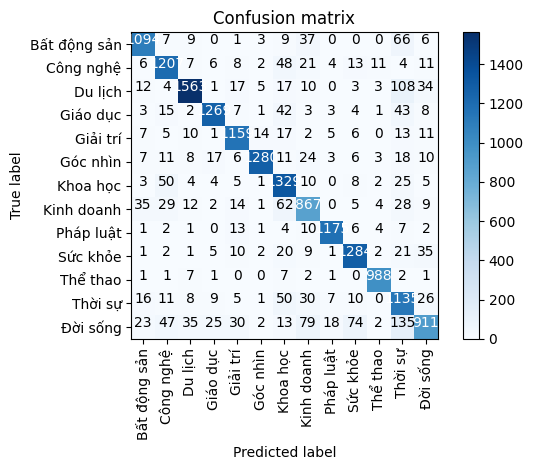

In [22]:
confusionMatrix(y_test_expanded, y_pred)

### Tính các độ đo của dữ liệu gốc 

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

# Load tokenizer và model đã huấn luyện
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
loaded_model = tf.saved_model.load("best1111_model")
infer = loaded_model.signatures["serving_default"]

# Hàm chia văn bản thành các đoạn nhỏ
def split_text(text, max_length=256):
    words = text.split()
    return [" ".join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

# Hàm dự đoán nhãn cho từng văn bản gốc từ các đoạn con
def predict_text_chunks(X_test, y_test):
    y_true = []
    y_pred = []

    for text, label in zip(X_test, y_test):
        text_chunks = split_text(text, max_length=256)
        chunk_probs = []
        chunk_labels = []

        for chunk in text_chunks:
            chunk_encoded = tokenizer(chunk, padding="max_length", truncation=True, return_tensors="tf", max_length=256)
            input_ids = tf.constant(chunk_encoded["input_ids"], dtype=tf.int32)
            attention_mask = tf.constant(chunk_encoded["attention_mask"], dtype=tf.int32)

            chunk_pred = infer(input_ids=input_ids, attention_mask=attention_mask)["dense_2"].numpy()
            chunk_probs.append(chunk_pred)
            chunk_labels.append(np.argmax(chunk_pred))  # Lấy nhãn có xác suất cao nhất cho từng chunk

        # Chọn nhãn xuất hiện nhiều nhất trong các văn bản con
        most_common_label = Counter(chunk_labels).most_common(1)[0][0]

        final_label = most_common_label  # Chọn nhãn phổ biến nhất

        y_true.append(label)
        y_pred.append(final_label)

    return np.array(y_true), np.array(y_pred)

# Chạy dự đoán
y_test_expanded, y_pred = predict_text_chunks(X_test, y_test)

# Tính các độ đo
accuracy = accuracy_score(y_test_expanded, y_pred)
precision = precision_score(y_test_expanded, y_pred, average='macro')
recall = recall_score(y_test_expanded, y_pred, average='macro')
f1 = f1_score(y_test_expanded, y_pred, average='macro')

# In kết quả
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9269
Precision: 0.9323
Recall: 0.9294
F1-score: 0.9293


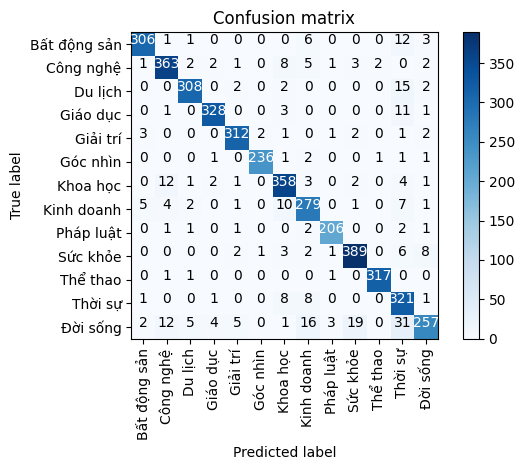

In [34]:
confusionMatrix(y_test_expanded, y_pred)